# Spatial-Temporal Graph Neural Network (Spatial-Temporal GNN)

Prediction of the intention of pedestrians to cross the street or not, using Graph Neural Networks and the coordinates of their skeleton that was previously obtained from CARLA simulator.

**Input:** Pedestrian skeleton graph.

**Output:** Binary classification (crossing or not crossing the street).

In [1]:
import numpy as np

from torch import from_numpy
from torch import cuda
from torch import no_grad
from torch import optim

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

import pandas as pd

%matplotlib inline

from Code.GNN import *
from Code.SkeletonsDataset import *
from Code.ModelTrainEvaluate import *
from Code.MetricsPlots import *

import time

/home/adas/anaconda3/envs/main/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

## Training dataset

In [2]:
info = 2

train_dataset = SkeletonsDataset('Data/CARLA/train_preprocessed.csv',
                                 normalization='minmax', target='crossing', info=info,
                                 numberOfJoints=26, remove_undetected=False)

print('train_dataset len:', len(train_dataset))
print('Temporal dimension length:', len(train_dataset.data[0].x_temporal))
print('Shape of each skeletons data (x):', train_dataset.data[0].x_temporal[0].shape)

train_dataset.loadedData

train_dataset len: 151545
Temporal dimension length: 2
Shape of each skeletons data (x): torch.Size([26, 3])


,Unnamed: 0.1,Unnamed: 0,id,video,frame,skeleton,crossing
0,274800,274800,d1d1c0e1-550a-44ae-9ada-e6b16e52ba48,clips/57-7-0-0.mp4,0,"[[-2805.490966796875, -93.4703369140625, 0], [...",0
1,274801,274801,d1d1c0e1-550a-44ae-9ada-e6b16e52ba48,clips/57-7-0-0.mp4,1,"[[-2785.79541015625, -79.54444122314453, 0], [...",0
2,274802,274802,d1d1c0e1-550a-44ae-9ada-e6b16e52ba48,clips/57-7-0-0.mp4,2,"[[-2765.295654296875, -65.11300659179688, 0], ...",0
3,274803,274803,d1d1c0e1-550a-44ae-9ada-e6b16e52ba48,clips/57-7-0-0.mp4,3,"[[-2744.0283203125, -50.199893951416016, 0], [...",0
4,274804,274804,d1d1c0e1-550a-44ae-9ada-e6b16e52ba48,clips/57-7-0-0.mp4,4,"[[-2722.03759765625, -34.829925537109375, 0], ...",0
...,...,...,...,...,...,...,...
151795,219595,219595,d37bcb41-11ce-4696-b6c9-3c663a44119a,clips/47-11-0-0.mp4,595,"[[-159.25418090820312, 2856.2373046875, 0], [-...",0
151796,219596,219596,d37bcb41-11ce-4696-b6c9-3c663a44119a,clips/47-11-0-0.mp4,596,"[[-158.1601104736328, 2856.507568359375, 0], [...",0
151797,219597,219597,d37bcb41-11ce-4696-b6c9-3c663a44119a,clips/47-11-0-0.mp4,597,"[[-157.06983947753906, 2856.77734375, 0], [-15...",0
151798,219598,219598,d37bcb41-11ce-4696-b6c9-3c663a44119a,clips/47-11-0-0.mp4,598,"[[-155.98318481445312, 2857.046142578125, 0], ...",0


Important columns:

In [3]:
train_dataset.loadedData[['video','frame','skeleton','crossing']]

,video,frame,skeleton,crossing
0,clips/57-7-0-0.mp4,0,"[[-2805.490966796875, -93.4703369140625, 0], [...",0
1,clips/57-7-0-0.mp4,1,"[[-2785.79541015625, -79.54444122314453, 0], [...",0
2,clips/57-7-0-0.mp4,2,"[[-2765.295654296875, -65.11300659179688, 0], ...",0
3,clips/57-7-0-0.mp4,3,"[[-2744.0283203125, -50.199893951416016, 0], [...",0
4,clips/57-7-0-0.mp4,4,"[[-2722.03759765625, -34.829925537109375, 0], ...",0
...,...,...,...,...
151795,clips/47-11-0-0.mp4,595,"[[-159.25418090820312, 2856.2373046875, 0], [-...",0
151796,clips/47-11-0-0.mp4,596,"[[-158.1601104736328, 2856.507568359375, 0], [...",0
151797,clips/47-11-0-0.mp4,597,"[[-157.06983947753906, 2856.77734375, 0], [-15...",0
151798,clips/47-11-0-0.mp4,598,"[[-155.98318481445312, 2857.046142578125, 0], ...",0


Number of elements per class:

Training dataset total rows: 151800
Training dataset crossing class samples: 79294
Training dataset not-crossing class samples: 72506


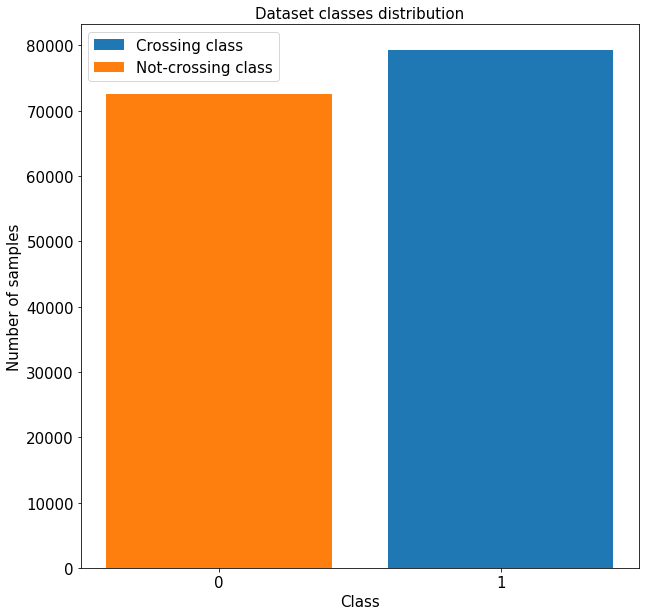

In [4]:
totalRows = len(train_dataset.loadedData)
crossingRows = len(train_dataset.loadedData[train_dataset.loadedData['crossing']==1])
nocrossingRows = len(train_dataset.loadedData[train_dataset.loadedData['crossing']!=1])

print('Training dataset total rows:', totalRows)
print('Training dataset crossing class samples:', crossingRows)
print('Training dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(10,10))
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='upper left', prop={'size': 15})
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution', size=15)
plt.show()

## Showing a skeleton

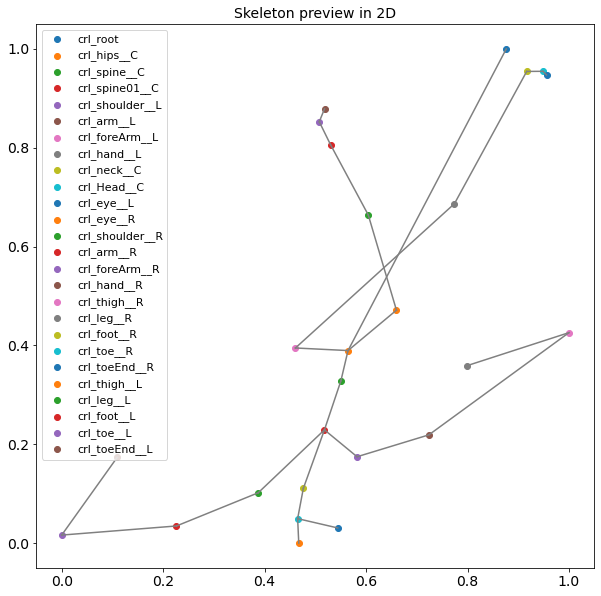

In [5]:
train_dataset.showSkeleton(videoNum=0, frameNum=0, textSize=14, showLegend=True, normalizedSkeletons=True)

## Validation dataset

In [6]:
val_dataset = SkeletonsDataset('Data/CARLA/val_preprocessed.csv',
                                 normalization='minmax', target='crossing', info=info,
                                 numberOfJoints=26, remove_undetected=False)

val_dataset.shuffle()

In [7]:
print('val_dataset len:', len(val_dataset))
print('Temporal dimension length:', len(val_dataset.data[0].x_temporal))
print('Shape of each skeletons data (x):', val_dataset.data[0].x_temporal[0].shape)

val_dataset.loadedData

val_dataset len: 60497
Temporal dimension length: 2
Shape of each skeletons data (x): torch.Size([26, 3])


,Unnamed: 0.1,Unnamed: 0,id,video,frame,skeleton,crossing
0,138600,138600,bf81180c-08e5-43bf-bee0-68db1ad37413,clips/28-13-0-0.mp4,0,"[[995.0813598632812, 297.71771240234375, 0], [...",1
1,138601,138601,bf81180c-08e5-43bf-bee0-68db1ad37413,clips/28-13-0-0.mp4,1,"[[994.7789916992188, 297.71392822265625, 0], [...",1
2,138602,138602,bf81180c-08e5-43bf-bee0-68db1ad37413,clips/28-13-0-0.mp4,2,"[[994.3765258789062, 297.70892333984375, 0], [...",1
3,138603,138603,bf81180c-08e5-43bf-bee0-68db1ad37413,clips/28-13-0-0.mp4,3,"[[993.8740844726562, 297.70269775390625, 0], [...",1
4,138604,138604,bf81180c-08e5-43bf-bee0-68db1ad37413,clips/28-13-0-0.mp4,4,"[[993.2706909179688, 297.6952209472656, 0], [1...",1
...,...,...,...,...,...,...,...
60595,260395,260395,f90a416b-c9a2-4a86-a3cd-5e2dc3290680,clips/54-10-0-0.mp4,595,"[[356.9145202636719, 3356.89208984375, 0], [35...",1
60596,260396,260396,f90a416b-c9a2-4a86-a3cd-5e2dc3290680,clips/54-10-0-0.mp4,596,"[[356.8764343261719, 3357.128662109375, 0], [3...",1
60597,260397,260397,f90a416b-c9a2-4a86-a3cd-5e2dc3290680,clips/54-10-0-0.mp4,597,"[[356.8384704589844, 3357.364501953125, 0], [3...",1
60598,260398,260398,f90a416b-c9a2-4a86-a3cd-5e2dc3290680,clips/54-10-0-0.mp4,598,"[[356.8006286621094, 3357.599609375, 0], [356....",1


Important columns:

In [8]:
val_dataset.loadedData[['video','frame','skeleton','crossing']]

,video,frame,skeleton,crossing
0,clips/28-13-0-0.mp4,0,"[[995.0813598632812, 297.71771240234375, 0], [...",1
1,clips/28-13-0-0.mp4,1,"[[994.7789916992188, 297.71392822265625, 0], [...",1
2,clips/28-13-0-0.mp4,2,"[[994.3765258789062, 297.70892333984375, 0], [...",1
3,clips/28-13-0-0.mp4,3,"[[993.8740844726562, 297.70269775390625, 0], [...",1
4,clips/28-13-0-0.mp4,4,"[[993.2706909179688, 297.6952209472656, 0], [1...",1
...,...,...,...,...
60595,clips/54-10-0-0.mp4,595,"[[356.9145202636719, 3356.89208984375, 0], [35...",1
60596,clips/54-10-0-0.mp4,596,"[[356.8764343261719, 3357.128662109375, 0], [3...",1
60597,clips/54-10-0-0.mp4,597,"[[356.8384704589844, 3357.364501953125, 0], [3...",1
60598,clips/54-10-0-0.mp4,598,"[[356.8006286621094, 3357.599609375, 0], [356....",1


Number of elements per class:

Validation dataset total rows: 60600
Validation dataset crossing class samples: 28074
Validation dataset not-crossing class samples: 32526


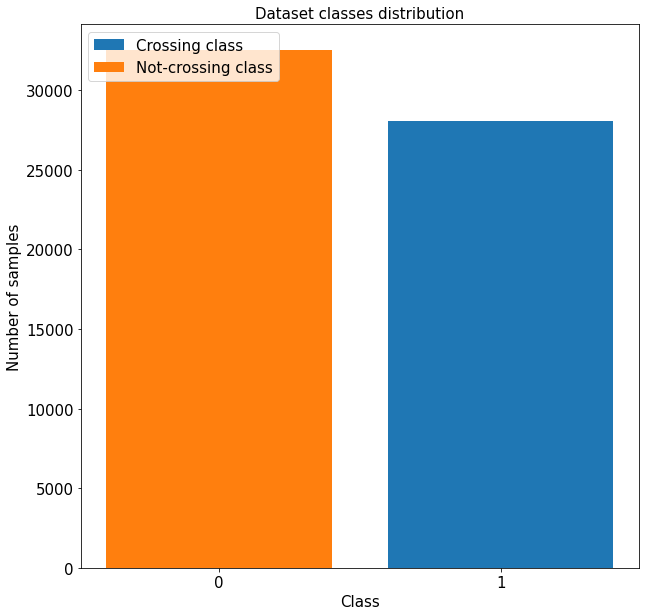

In [9]:
totalRows = len(val_dataset.loadedData)
crossingRows = len(val_dataset.loadedData[val_dataset.loadedData['crossing']==1])
nocrossingRows = len(val_dataset.loadedData[val_dataset.loadedData['crossing']!=1])

print('Validation dataset total rows:', totalRows)
print('Validation dataset crossing class samples:', crossingRows)
print('Validation dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(10,10))
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='upper left', prop={'size': 15})
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution', size=15)
plt.show()

Since the classes of the two datasets are unbalanced, we cannot rely only on accuracy as our metric.

## Showing a skeleton

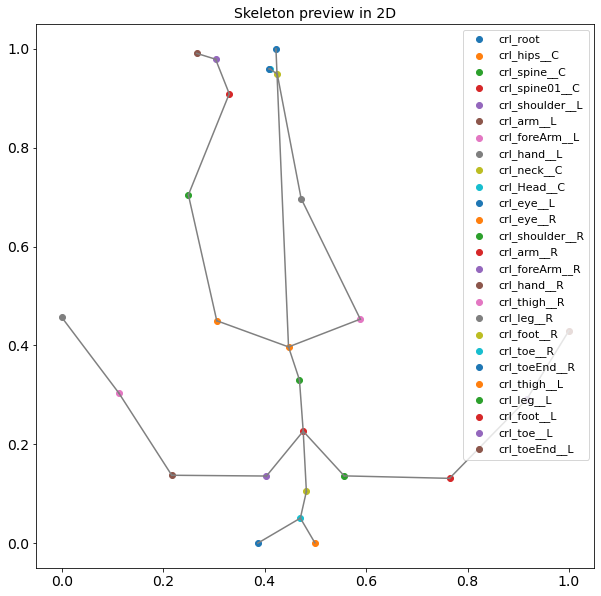

In [10]:
val_dataset.showSkeleton(videoNum=0, frameNum=0, textSize=14, showLegend=True, normalizedSkeletons=True)

# Training

In [11]:
numberOfClasses = 2

y = train_dataset.loadedData['crossing'].to_numpy()
y = np.where(y==1, 1, 0)
bc = np.bincount(y)

class_weights = len(train_dataset.loadedData) / (numberOfClasses * bc)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print('class_weights:', class_weights)

class_weights: tensor([1.0468, 0.9572])


In [12]:
train_dataset.shuffle()

In [13]:
# First element of training subset:
t0 = train_dataset[0]

# Node features:
t1 = t0.x_temporal[0]

# Number of nodes:
numberOfNodes = t1.shape[0]

# Number of dimensions of each node features:
embed_dim = t1.shape[1]

print('Number of nodes per skeleton:', numberOfNodes)
print('Number of features per node:', embed_dim)

Number of nodes per skeleton: 26
Number of features per node: 3


In [14]:
num_epochs = 200
batch_size = 500

device = torch.device('cuda')
torch.cuda.set_device(0)
model = SpatialTemporalGNN(embed_dim, numberOfClasses, numberOfNodes, net='GConvGRU', filterSize=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=0.001)
crit = torch.nn.BCELoss()#weight=class_weights)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

loss_values = []

metrics_train = []
metrics_val = []

start_time_total_training = time.time()

for epoch in range(num_epochs):

    start_time = time.time()
    train_loss = train(model, train_loader, device, optimizer, crit)
    end_time = time.time()
    train_time_epoch = (end_time - start_time) / 60
    loss_values.append(train_loss)

    train_metrics = evaluate(model, train_loader, device, computed_loss=train_loss)
    
    start_time = time.time()
    val_metrics = evaluate(model, val_loader, device, loss_crit=crit)
    end_time = time.time()
    val_time_epoch = (end_time - start_time) / 60
    
    train_metrics["Epoch"] = int(epoch)
    val_metrics["Epoch"] = int(epoch)
    
    train_metrics["Step time (minutes)"] = train_time_epoch
    val_metrics["Time (minutes)"] = val_time_epoch
    
    metrics_train.append(train_metrics)
    metrics_val.append(val_metrics)
    
    if num_epochs <= 25 or epoch % 10 == 0:
        
        print_evaluation_train_val(epoch, train_metrics, val_metrics)
        
        
    modelFileName = 'exportedModels/CARLA/Full train dataset/SpatialTemporal - ' + str(info) + ' frames/'
    torch.save(model.state_dict(), modelFileName + 'Epoch_' + str(epoch))
    
    metrics_df_train = pd.DataFrame(metrics_train)
    metrics_df_train.to_csv(modelFileName + 'train_metrics.csv')
    
    metrics_df_val = pd.DataFrame(metrics_val)
    metrics_df_val.to_csv(modelFileName + 'val_metrics.csv')
    
end_time_total_training = time.time()
time_total_training = (end_time_total_training - start_time_total_training) / 60

if time_total_training < 60:
    print("Total training time during {:d} epochs: {:0.2f} minutes.".format(num_epochs, time_total_training))
else:
    print("Total training time during {:d} epochs: {:0.2f} hours.".format(num_epochs, time_total_training / 60))

Epoch:                           001
Train Loss:                   0.5940  -  Validation Loss:                   0.5360
Train Accuracy:               0.8440  -  Validation Accuracy:               0.7660
Train Balanced accuracy:      0.8437  -  Validation Balanced accuracy:      0.7670
Train Precision:              0.8528  -  Validation Precision:              0.7325
Train Recall:                 0.8490  -  Validation Recall:                 0.7822
Train f1-score:               0.8509  -  Validation f1-score:               0.7565
Train Step time (minutes):    0.2567  -  Validation Time (minutes):         8.8889
 


Epoch:                           011
Train Loss:                   0.3230  -  Validation Loss:                   0.4012
Train Accuracy:               0.9041  -  Validation Accuracy:               0.8241
Train Balanced accuracy:      0.9032  -  Validation Balanced accuracy:      0.8265
Train Precision:              0.8977  -  Validation Precision:              0.7823
Train Rec

Epoch:                           141
Train Loss:                   0.3077  -  Validation Loss:                   0.4293
Train Accuracy:               0.9102  -  Validation Accuracy:               0.8105
Train Balanced accuracy:      0.9112  -  Validation Balanced accuracy:      0.8071
Train Precision:              0.9345  -  Validation Precision:              0.8200
Train Recall:                 0.8913  -  Validation Recall:                 0.7590
Train f1-score:               0.9124  -  Validation f1-score:               0.7883
Train Step time (minutes):    0.2517  -  Validation Time (minutes):         0.0644
 


Epoch:                           151
Train Loss:                   0.3070  -  Validation Loss:                   0.4356
Train Accuracy:               0.9133  -  Validation Accuracy:               0.8173
Train Balanced accuracy:      0.9135  -  Validation Balanced accuracy:      0.8164
Train Precision:              0.9234  -  Validation Precision:              0.8037
Train Rec

## Model performance plots

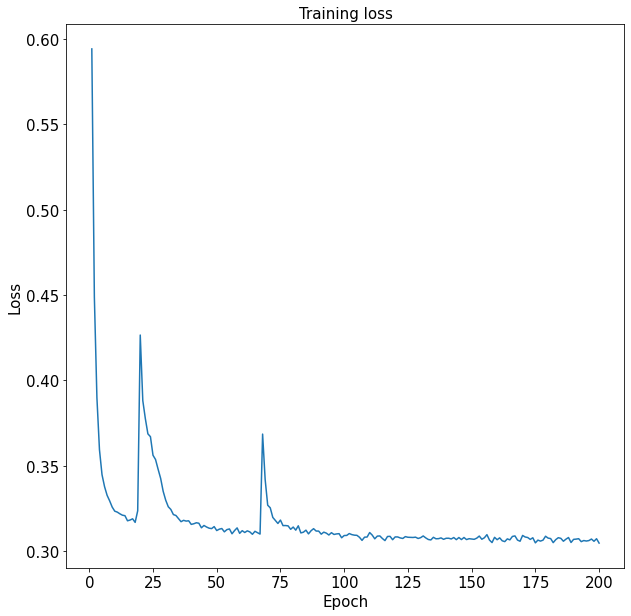

In [15]:
plot_loss(num_epochs, loss_values, figsize=10, textsize=15)

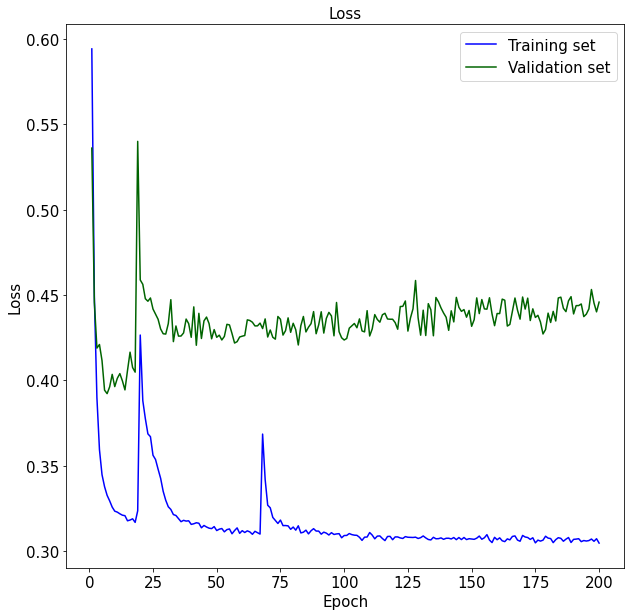

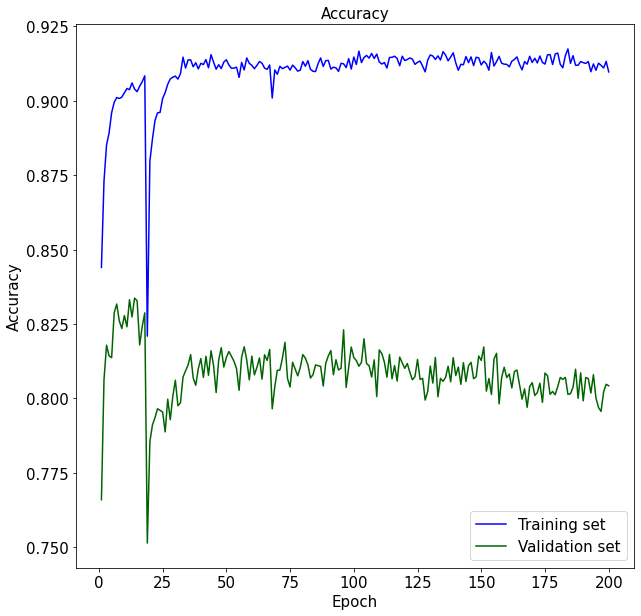

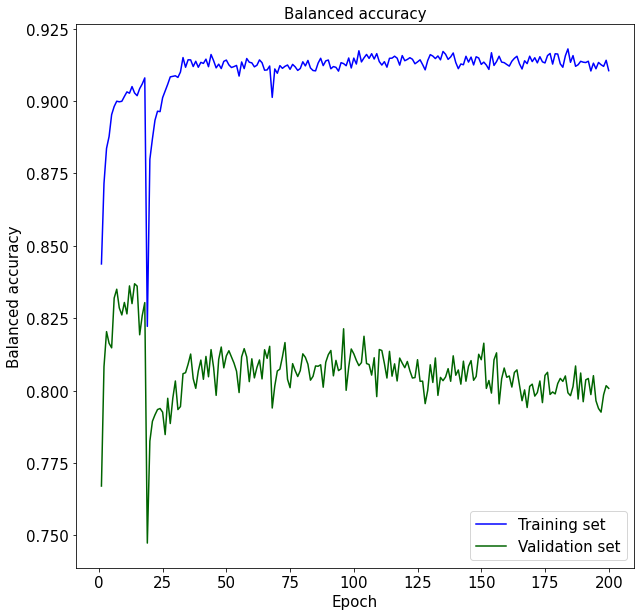

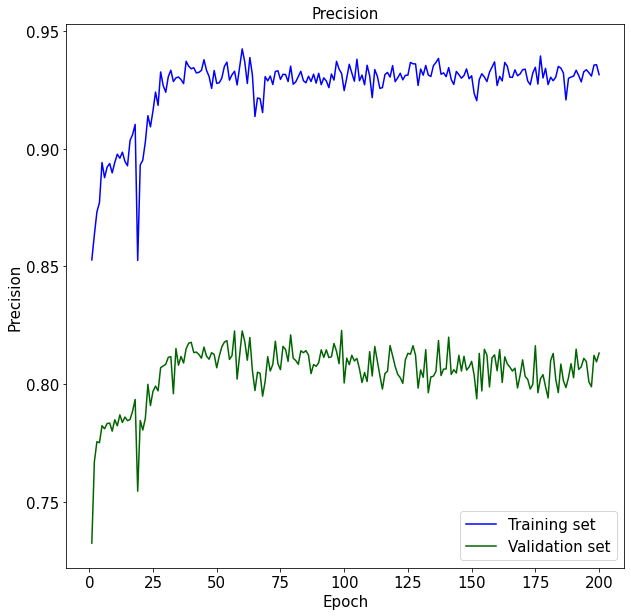

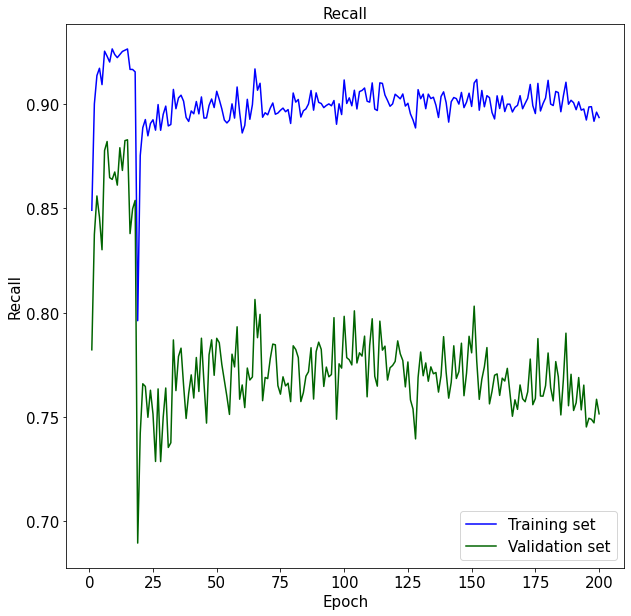

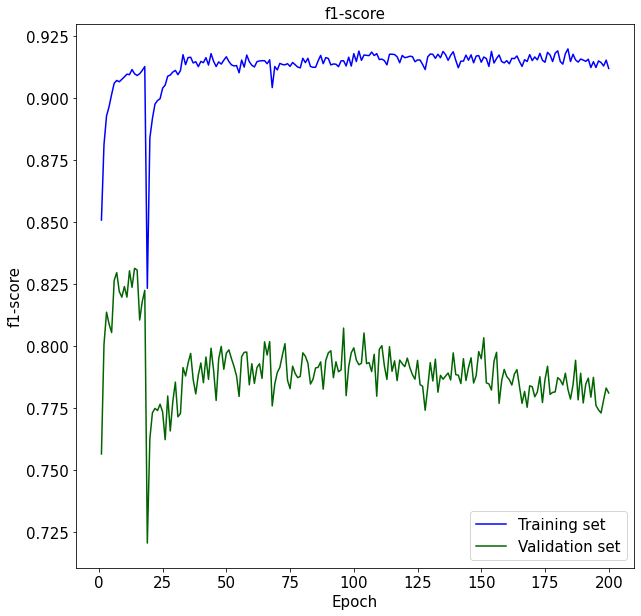

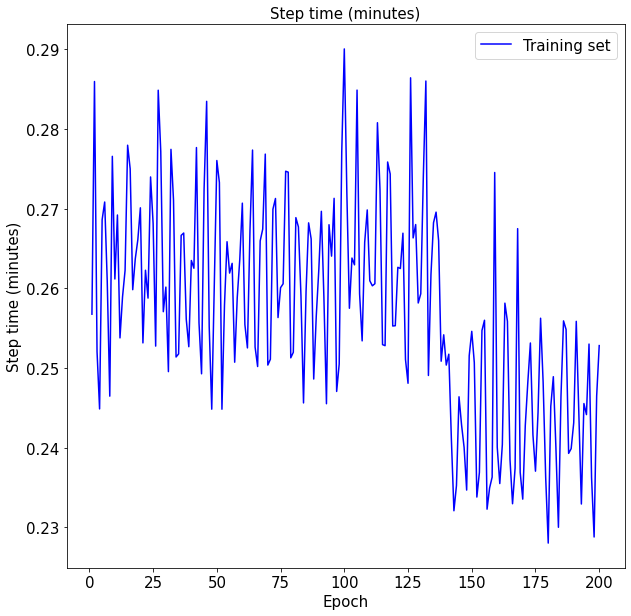

In [16]:
plot_classification_metrics_train_val(num_epochs, metrics_train, metrics_val, figsize=10, textsize=15)

## ROC curves

### Train set

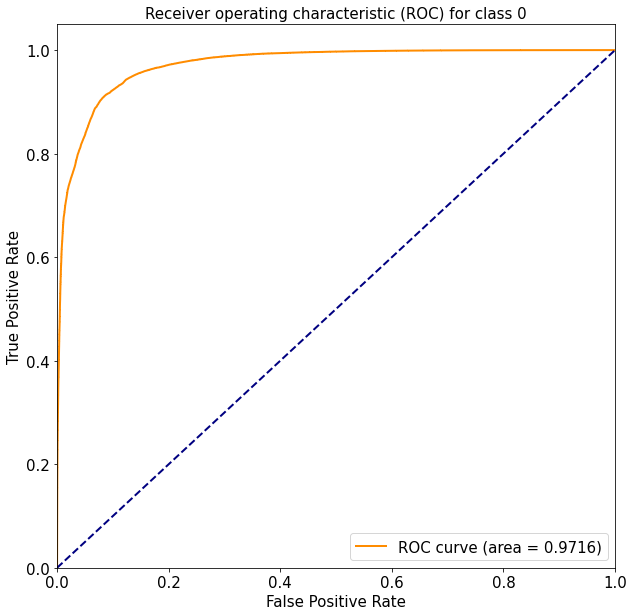

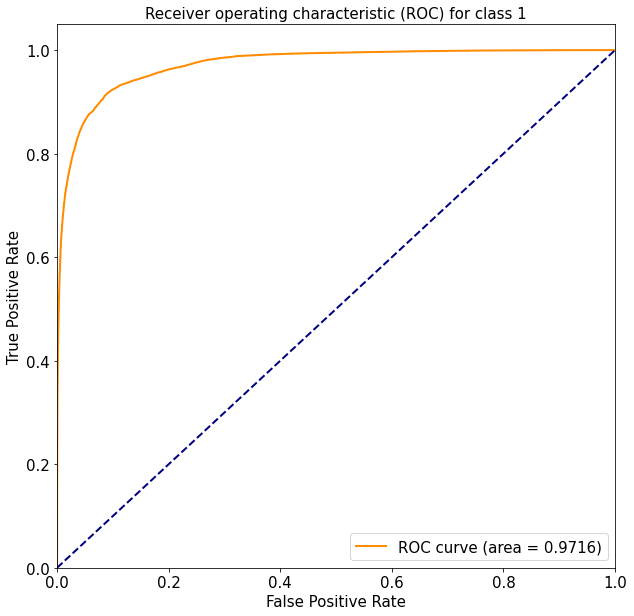

In [17]:
fpr, tpr, roc_auc = ROC(model, train_loader, device, numberOfClasses)

for plotclass in range(0, numberOfClasses):
    plot_ROC(plotclass, fpr, tpr, roc_auc)

### Validation set

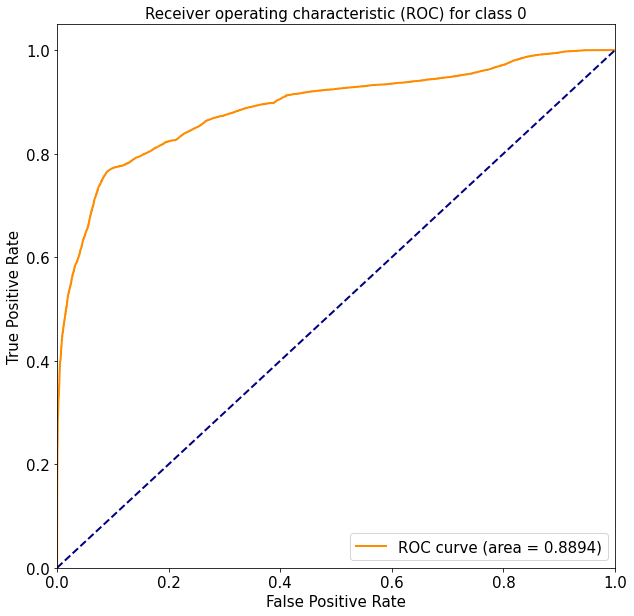

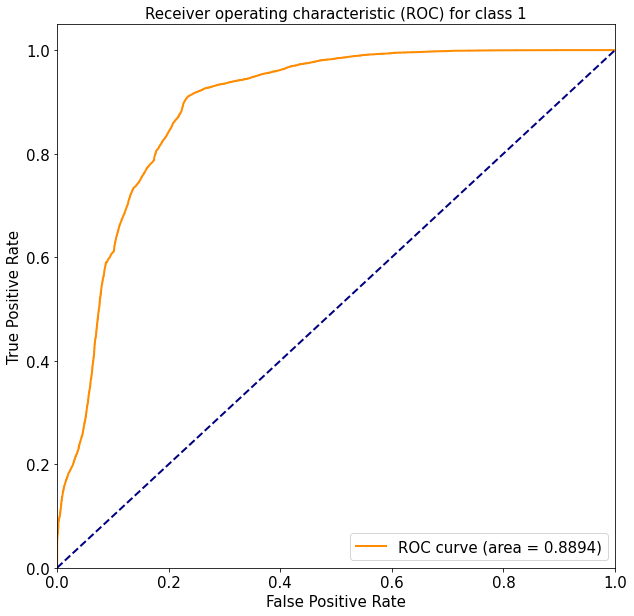

In [18]:
fpr, tpr, roc_auc = ROC(model, val_loader, device, numberOfClasses)

for plotclass in range(0, numberOfClasses):
    plot_ROC(plotclass, fpr, tpr, roc_auc)

# Testing

## Test dataset

In [19]:
test_dataset = SkeletonsDataset('Data/CARLA/test_preprocessed.csv',
                                 normalization='minmax', target='crossing', info=info,
                                 numberOfJoints=26, remove_undetected=False)

Number of elements per class:

Test dataset total rows: 91800
Test dataset crossing class samples: 50280
Test dataset not-crossing class samples: 41520


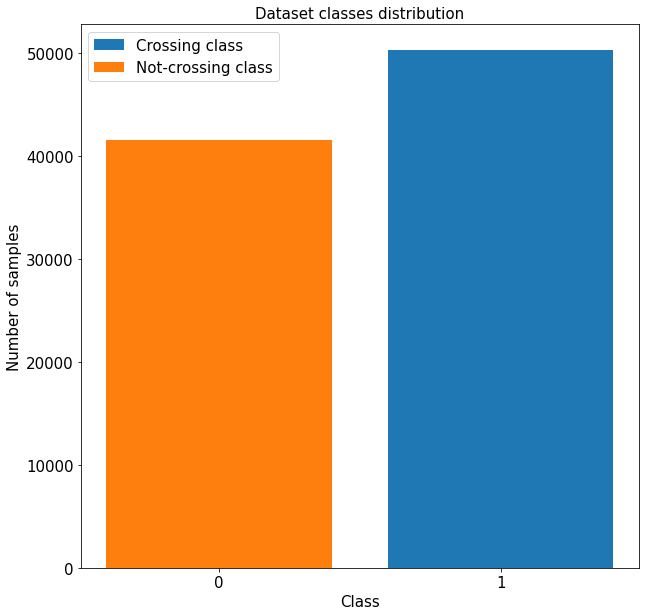

In [20]:
totalRows = len(test_dataset.loadedData)
crossingRows = len(test_dataset.loadedData[test_dataset.loadedData['crossing']==1])
nocrossingRows = len(test_dataset.loadedData[test_dataset.loadedData['crossing']!=1])

print('Test dataset total rows:', totalRows)
print('Test dataset crossing class samples:', crossingRows)
print('Test dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(10,10))
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='upper left', prop={'size': 15})
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution', size=15)
plt.show()

## Test results

In [21]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

start_time = time.time()
test_metrics = evaluate(model, test_loader, device)
end_time = time.time()
test_time_epoch = (end_time - start_time) / 60

test_metrics["Test time (minutes)"] = test_time_epoch

print_evaluation_test(test_metrics)

metrics_df_test = pd.DataFrame([test_metrics])
metrics_df_test.to_csv(modelFileName + 'test_metrics.csv')

Testing subset results:

Accuracy:                 0.8778
Balanced accuracy:        0.8816
Precision:                0.9272
Recall:                   0.8440
f1-score:                 0.8837
Test time (minutes):      0.0940
 


